# Atividade 3: xG

## Referências

- [Soccermatics](https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html)
- [kloppy](https://kloppy.pysport.org)
- [socceraction](https://socceraction.readthedocs.io/en/latest)
- [socceraction: Wyscout -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.wyscout.convert_to_actions.html)
- [socceraction: Statsbomb -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.statsbomb.convert_to_actions.html)

# **Bibliotecas**


Nome: Bernardo Vale dos Santos Bento

Matrícula: 2023002065

In [51]:
import sys

if 'google.colab' in sys.modules:
  %pip install --upgrade mplsoccer

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from mplsoccer import VerticalPitch
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
eventos = pd.read_json("events_World_Cup.json")
jogadores = pd.read_json("players.json")

jogadores['nome'] = jogadores['firstName'].fillna('') + " " + \
                    jogadores['middleName'].fillna('') + " " + \
                    jogadores['lastName'].fillna('')

jogadores = jogadores[['wyId', 'nome']]

eventos = eventos.merge(jogadores, left_on='playerId', right_on='wyId', how='left')

random_match_id = eventos['matchId'].sample(n=1).iloc[0]

## Questão 1

Baixe o dataset [Wyscout Europa Top 5 2017/2018](https://figshare.com/collections/Soccer_match_event_dataset/4415000).

* Vá até o final da página. Lá você vai encontrar múltiplos datasets. O principal é o de Eventos; mas use os demais para adicionar informações (como correspondência id<->jogador)

Escolha uma partida e carregue os dados de eventos em um dataframe do pandas.

In [4]:
partida = eventos[eventos['matchId'] == random_match_id]

### 1.1

Crie um dataframe "shots", contendo apenas os chutes.

Adicione colunas no dataframe "shots" a serem usadas como as features de um modelo de xG.

Justifique a escolha das features.

In [5]:
chutes = eventos[eventos['subEventName'] == 'Shot'].copy()
chutes['gol'] = chutes['tags'].apply(lambda tags: 1 if any(tag.get('id') == 101 for tag in tags) else 0)

chutes["x"] = chutes.positions.apply(lambda cell: (100 - cell[0]['x']) * 105 / 100)
chutes["y"] = chutes.positions.apply(lambda cell: cell[0]['y'] * 68 / 100)
chutes["dl"] = chutes.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68 / 100)

chutes["distancia"] = np.sqrt(chutes["x"]**2 + chutes["dl"]**2)

angulo_puro = np.arctan(
    (7.32 * chutes["x"]) /
    (chutes["x"]**2 + chutes["dl"]**2 - (7.32/2)**2)
)
chutes["angulo"] = np.where(angulo_puro > 0, angulo_puro, angulo_puro + np.pi)

**Colunas adicionadas:**

- Ângulo;
- x, y e dl(distancia lateral - em relação ao gol);
- Distância
- gol;

Foram criadas para evitar o calculo repetido de dados implícitos, princiapalmente se foi gol ou não, que está mascarado dentro da coluna 'tags'

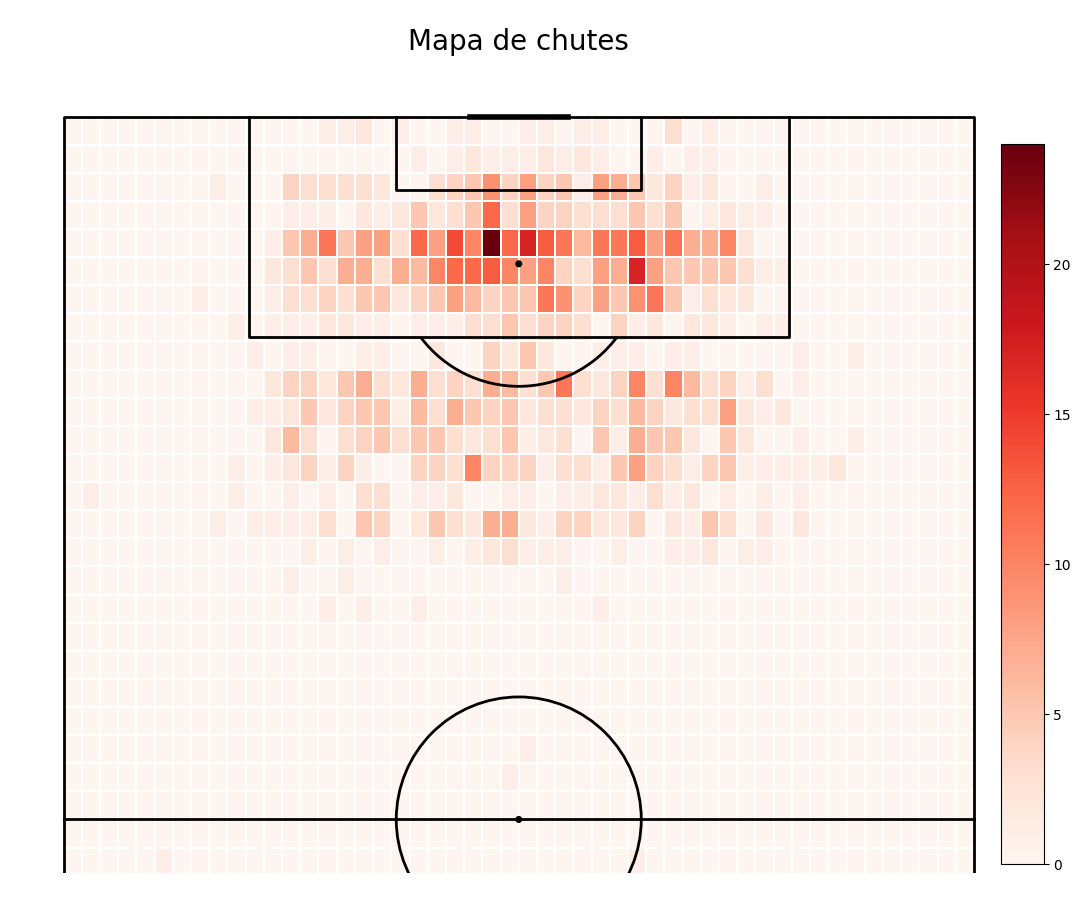

In [6]:
campo = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = campo.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic_shots = campo.bin_statistic(105 - chutes['x'], chutes['y'], bins=50)

pcm = campo.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

fig.suptitle('Mapa de chutes' , fontsize = 20)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
plt.show()

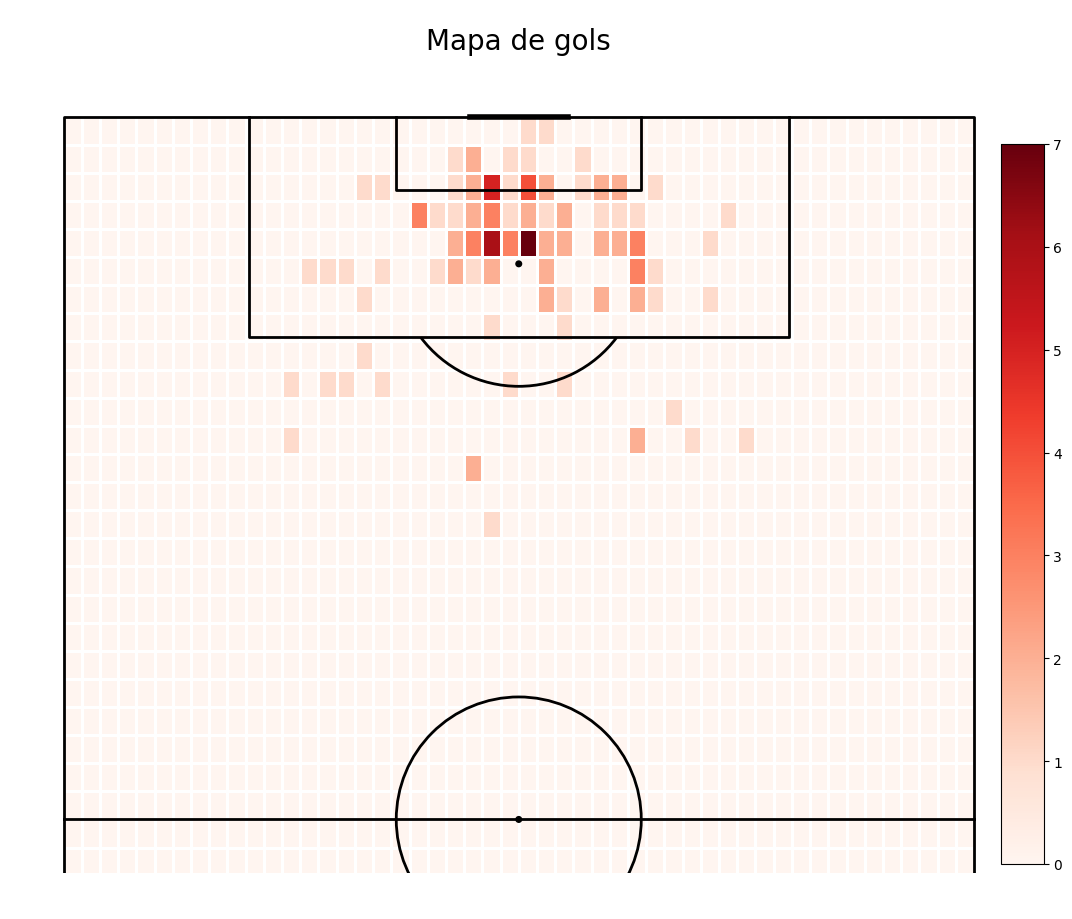

In [7]:
gols = chutes[chutes['gol'] == 1]

campo = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = campo.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic_goals = campo.bin_statistic(105 - gols.x, gols.y, bins=50)

pcm = campo.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Mapa de gols' , fontsize = 20)
plt.show()

<ipython-input-8-04bede1e4cac>:6: RuntimeWarning: invalid value encountered in divide
  bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]


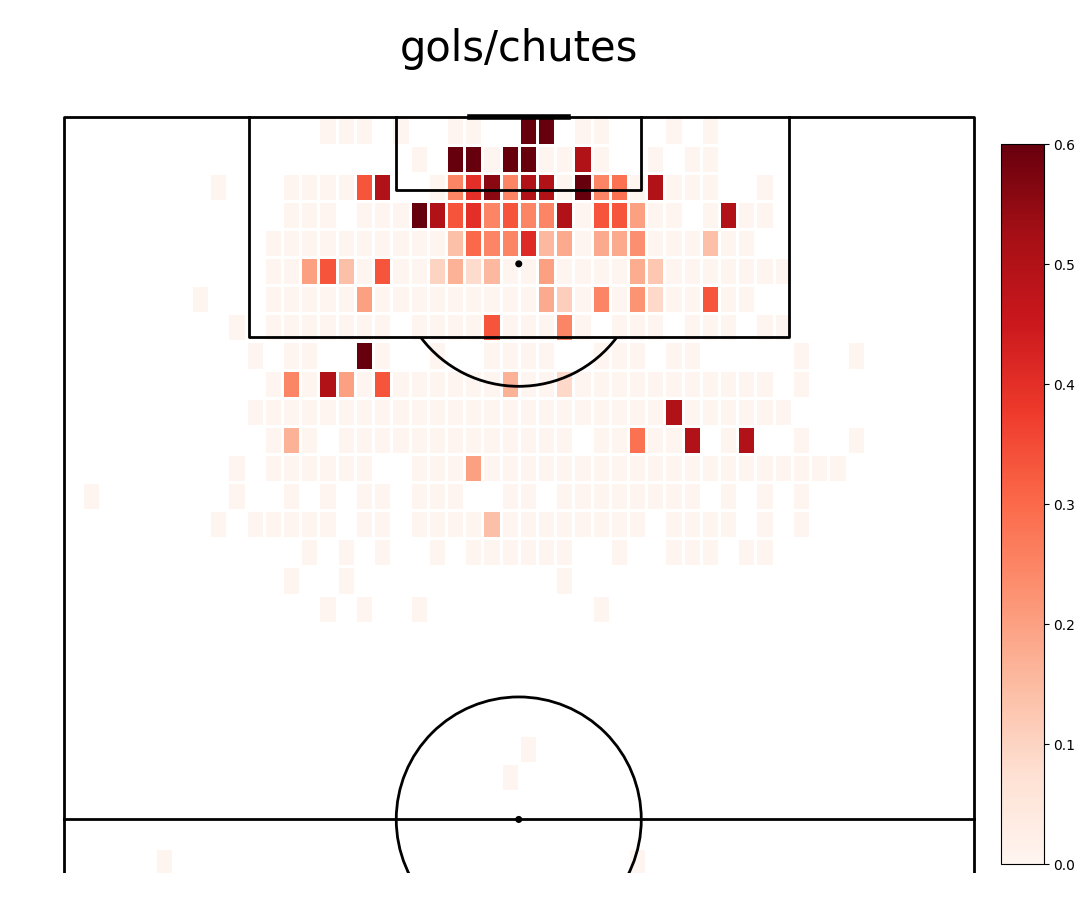

In [8]:
campo = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = campo.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = campo.bin_statistic(105 - chutes.x, chutes.y, bins = 50)

bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

pcm = campo.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('gols/chutes' , fontsize = 30)
plt.show()

## Questão 2

Agora, crie seu próprio modelo de *expected goals*. Use os slides como guia -- você tem liberdade de usar qualquer método (ex: [regressão logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    gol   No. Observations:                 1419
Model:                            GLM   Df Residuals:                     1417
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.95
Date:                Tue, 08 Apr 2025   Deviance:                       741.90
Time:                        14:55:09   Pearson chi2:                 1.30e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.07982
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0028      0.212    -18.877      0.0

<ipython-input-22-01bdf9c8b0a0>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xGprob = 1 / (1 + np.exp(-(b[0] + b[1]*midangle*np.pi/180)))


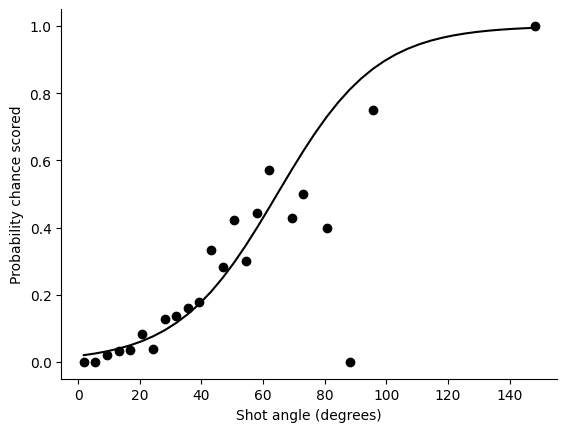

In [22]:
shotcount_dist = np.histogram(chutes['angulo']*180/np.pi, bins=40, range=[0, 150])
goalcount_dist = np.histogram(gols['angulo']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2

b = [2, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))

#calculate xG
xg = 1/(1+np.exp(b[0]+b[1]*chutes['angulo']))
chutes = chutes.assign(xg = xg)

#create model
test_model = smf.glm(formula="gol ~ angulo" , data=chutes,
                           family=sm.families.Binomial()).fit()

print(test_model.summary())
#get params
b=test_model.params
#calculate xG
xGprob = 1 / (1 + np.exp(-(b[0] + b[1]*midangle*np.pi/180)))
fig, ax = plt.subplots()
#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    gol   No. Observations:                 1419
Model:                            GLM   Df Residuals:                     1417
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -368.70
Date:                Tue, 08 Apr 2025   Deviance:                       737.39
Time:                        14:55:12   Pearson chi2:                 1.67e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.08274
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2438      0.250      0.974      0.3

<ipython-input-23-760377d0c69b>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xGprob=1/(1+np.exp(-(b[0]+b[1]*middistance)))


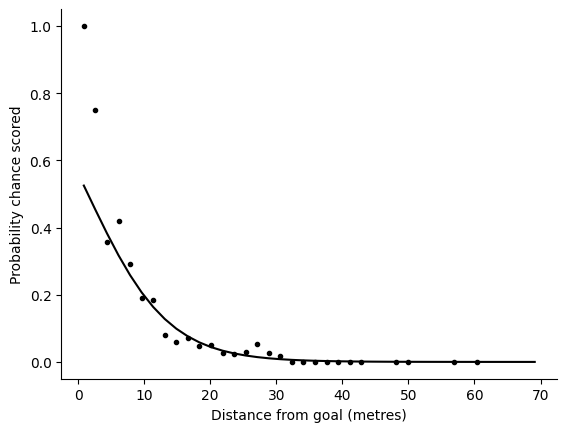

In [23]:
#number of shots
shotcount_dist = np.histogram(chutes['distancia'],bins=40,range=[0, 70])
#number of goals
goalcount_dist = np.histogram(gols['distancia'],bins=40,range=[0, 70])
#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#make single variable model of distance
test_model = smf.glm(formula="gol ~ distancia" , data=chutes,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(-(b[0]+b[1]*middistance)))
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    gol   No. Observations:                 1419
Model:                            GLM   Df Residuals:                     1413
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -362.22
Date:                Tue, 08 Apr 2025   Deviance:                       724.45
Time:                        14:55:15   Pearson chi2:                 1.42e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09107
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3733      1.383     -0.993      0.3

<ipython-input-24-52ccd8dd7fb4>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum=b[0]
<ipython-input-24-52ccd8dd7fb4>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum=bsum+b[i+1]*sh[v]


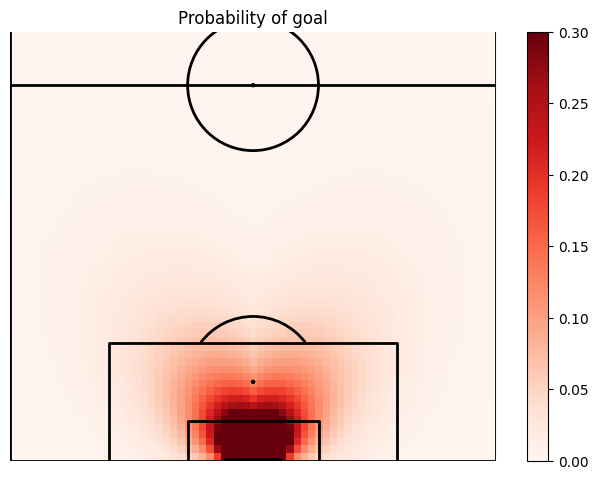

In [24]:
#creating extra variables
chutes["ax"]  = chutes['angulo']*chutes['x']

# list the model variables you want here
model_variables = ['angulo','distancia','x','dl', "ax"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#fit the model
test_model = smf.glm(formula="gol ~ " + model, data=chutes,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params

#return xg value for more general model
def calculate_xg(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xg = 1/(1+np.exp(-bsum))
   return xg

#add an xg to my dataframe
xg=chutes.apply(calculate_xg, axis=1)
chutes = chutes.assign(xg=xg)

#Create a 2D map of xg
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['angulo'] = a
        sh['distancia'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['x'] = x
        sh['ax'] = x*a
        sh['dl'] = abs(y-68/2)

        pgoal_2d[x,y] = calculate_xg(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.1

Faça uma curva de calibração para avaliar a qualidade do seu modelo para diferentes probabilidades de gol.

Dica: use a função:

```
from sklearn.calibration import calibration_curve
# calibration_curve(y, y_pred, n_bins=10)
```

Discuta os resultados: seu modelo está *bem calibrado*?


In [25]:
y_np = chutes['gol'].to_numpy().reshape(-1, 1)
y_pred = chutes['xg'].to_numpy().reshape(-1, 1)

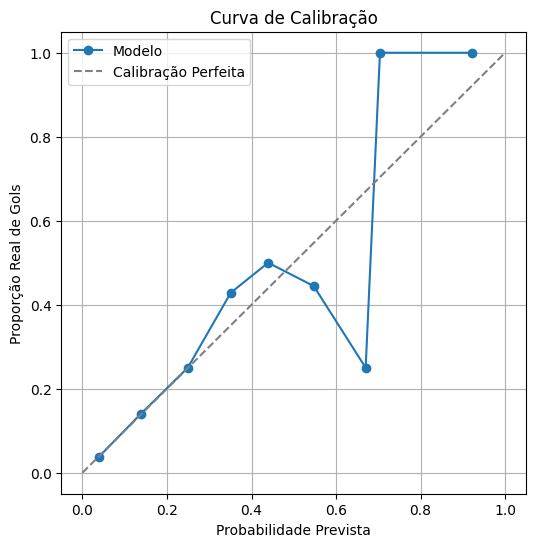

In [26]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_np, y_pred, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibração Perfeita')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Proporção Real de Gols')
plt.title('Curva de Calibração')
plt.legend()
plt.grid(True)
plt.show()

Baseado no banco de dados da Copa do Mundo, o modelo prevê bem chutes de baixo potencial de gols, e começa a distoar dos resultados reais quando se aproxima de lances mais certeiros. Apesar que isso possa ser fruto da baixa amostragem de jogos que existe em uma Copa do Mundo, como pode ser observado no 7 ponto (da direita para a esquerda) que cai inexplicavelmente na proporção real de gols.

## Questão 3
Aplique o seu model de xG treinado na questão anterior para prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".

Em seguida, crie duas listas, exibindo:
- os 10 jogadores com maior xG
- os 10 jogadores com maior diferença de Gols e xG

Discuta os resultados.
- O seu modelo fez um bom trabalho para prever os gols?
- Como você explica a diferença de gols e xG?

In [28]:
# Agrupando por jogador
jogadores = chutes.groupby(['playerId']).agg({
    'nome': 'first',
    'gol': 'sum',
    'xg': 'sum'
}).reset_index()

# Renomeando as colunas para clareza
jogadores.rename(columns={
    'playerId': 'id',
    'gol': 'gols',
    'xg': 'xg'
}, inplace=True)

print(jogadores.sort_values(by='xg', ascending=False).head(10)[['nome', 'xg','gols']])

jogadores['dif_gol_xg'] = jogadores['gols'] - jogadores['xg']
print(jogadores.sort_values(by='dif_gol_xg', ascending=False).head(10)[['nome', 'dif_gol_xg', 'gols']])
print(jogadores['dif_gol_xg'].mean())

                                     nome        xg  gols
165        Neymar  da Silva Santos Junior  2.566463     2
94                           Marcus  Berg  2.477616     0
124    Edinson Roberto  Cavani G\u00f3mez  2.361209     3
49                  Romelu  Lukaku Menama  2.296604     4
99             Mario  Mand\u017euki\u0107  2.287980     3
88                Ivan  Peri\u0161i\u0107  2.006233     3
305             Aleksandar  Mitrovi\u0107  1.959990     1
70                            Harry  Kane  1.772810     3
107  Roberto Firmino  Barbosa de Oliveira  1.668103     1
45                  Diego  da Silva Costa  1.602069     3
                                        nome  dif_gol_xg  gols
47                          Denis  Cheryshev    3.298259     4
372               Kylian  Mbapp\u00e9 Lottin    2.629931     4
344       Yerry Fernando  Mina Gonz\u00e1lez    2.008113     3
49                     Romelu  Lukaku Menama    1.703396     4
91                             Takashi  Inui   

Baseando-se exclusivamente nas duas listas, é difícl de analisar a precisão do modelo. Porém vendo que a média da diferença entre gols e xg, obtemos o valor ~ 1e-15 que pode ser interpretado como 0, ou seja, em média, o modelo prevê bem as chances de gols.

Porém, ainda há muito que melhorar no modelo, para que ele acerte não só na média, como distância para o goleiro, força do chute, desequilíbrio de quem chuta, entre outras questões.

## Questão 4 (opcional)
Carregue os [dados das 5 grandes ligas européias do StatsBomb](https://statsbomb.com/news/the-2015-16-big-5-leagues-free-data-release-la-liga/). Use o [guia do statsbomb para carregar os dados](https://statsbomb.com/articles/soccer/using-statsbomb-free-data-in-python/), se quiser.

Note que as métricas e o formato dos dados são diferentes.

Com os dados da StatsBomb, crie um novo modelo de xG. Você pode usar as mesmas ideias do modelo da questão 1, ou pode fazer um modelo novo.

Compare e discuta seus resultados.

In [52]:
if 'google.colab' in sys.modules:
  %pip install --upgrade statsbombpy
  %pip install --upgrade socceraction[statsbomb]
  %pip install numpy<2.0

/bin/bash: line 1: 2.0: No such file or directory


In [55]:
from statsbombpy import sb
import socceraction.spadl

laliga = sb.matches(competition_id=11, season_id=27)
bundes = sb.matches(competition_id=9, season_id=27)
prem = sb.matches(competition_id=2, season_id=27)
seriea = sb.matches(competition_id=12, season_id=27)
ligue1 = sb.matches(competition_id=7, season_id=27)
eventosTodos = pd.DataFrame()

for partida in laliga.iterrows():
  eventos = sb.events(match_id=partida[1]['match_id'])
  eventos = socceraction.spadl.statsbomb.convert_to_actions(
      eventos,
      partida[1]['home_team_id'],
      xy_fidelity_version = partida[1]['xy_fidelity_version'],
      shot_fidelity_version = partida[1]['shot_fidelity_version']
      )
  eventosTodos = pd.concat([eventosTodos, eventos])

AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.

A bilioteca socceraction.spadl usa um código desatualizado como demonstrado pela mensagem de erro: AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.

Mesmo instalando a versão anterior da biblioteca numpy, o código não funciona.

**Código sem uso do spadl:**

Recomendo não rodar: Gasto excessivo de RAM (Utilizou todo meu limite do google colab)

In [ ]:

laliga = sb.matches(competition_id=11, season_id=27)
bundes = sb.matches(competition_id=9, season_id=27)
prem = sb.matches(competition_id=2, season_id=27)
seriea = sb.matches(competition_id=12, season_id=27)
ligue1 = sb.matches(competition_id=7, season_id=27)

eventosTodos = pd.DataFrame()
ligas = pd.DataFrame()

ligas = pd.concat([ligas, laliga])
ligas = pd.concat([ligas, bundes])
ligas = pd.concat([ligas, prem])
ligas = pd.concat([ligas, seriea])

for partida in ligas.iterrows():
  eventos = sb.events(match_id=partida[1]['match_id'])
  eventosTodos = pd.concat([eventosTodos, eventos])

#não consigo programar o resto, por não conseguir concatenar os dataframes em um só